### Tables & plots for paper

In [2]:
import importlib
import os
import pickle
import random

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import average_precision_score, roc_auc_score

from suitability.datasets.wilds import get_wilds_dataset, get_wilds_model
from suitability.filter import suitability_efficient

importlib.reload(suitability_efficient)

from suitability.filter.suitability_efficient import SuitabilityFilter, get_sf_features

# Set seeds for reproducibility
random.seed(32)
np.random.seed(32)

## Main Result

In [ ]:
def calculate_metrics(df, significance_level=0.05):
    # Ensure ground_truth and p_value are present
    if "ground_truth" not in df.columns or "p_value" not in df.columns:
        raise ValueError("DataFrame must contain 'ground_truth' and 'p_value' columns.")

    # Calculate ROC AUC and PR AUC
    roc_auc = roc_auc_score(
        df["ground_truth"], -df["p_value"]
    )  # Negating p_value as lower is better
    pr_auc = average_precision_score(df["ground_truth"], -df["p_value"])

    # Calculate predictions based on significance level
    predictions = (df["p_value"] <= significance_level).astype(int)

    # Calculate Accuracy
    accuracy = (predictions == df["ground_truth"]).mean()

    # Calculate False Positive Rate (FPR)
    false_positives = ((predictions == 1) & (df["ground_truth"] == 0)).sum()
    true_negatives = (df["ground_truth"] == 0).sum()
    fpr = false_positives / true_negatives if true_negatives > 0 else 0.0

    return {
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Accuracy": accuracy,
        "FPR": fpr,
    }

## SHAP & ANOVA for regressor

In [53]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import shap

cache_file = "suitability/results/features/fmow_ERM_last_0_combined_id.pkl"

if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        id_splits_features_cache = pickle.load(f)
        print("Features loaded")

features = id_splits_features_cache["features"]
corr = id_splits_features_cache["corr"]

permutation = np.random.permutation(len(features))

features_shuffled = features[permutation]
corr_shuffled = corr[permutation]

# Split the data
train_size = 0.8
train_features, test_features, train_corr, test_corr = train_test_split(
    features_shuffled, corr_shuffled, train_size=train_size
)

# Train the prediction correctness estimator
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

classifiers = ["logistic_regression"]
for classifier in classifiers:
    print(f"Classifier: {classifier}")
    # Train the prediction correctness estimator
    if classifier == "logistic_regression":
        base_model = LogisticRegression(max_iter=1000)
    elif classifier == "svm":
        base_model = SVC(probability=True)
    elif classifier == "random_forest":
        base_model = RandomForestClassifier()
    elif classifier == "gradient_boosting":
        base_model = GradientBoostingClassifier()
    elif classifier == "mlp":
        base_model = MLPClassifier(max_iter=1000)
    elif classifier == "mlp_2":
        base_model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100, 100))
    elif classifier == "decision_tree":
        base_model = DecisionTreeClassifier()

    model = base_model
    model.fit(train_features, train_corr)

    test_corr_pred = model.predict(test_features)

    print(f"{100*accuracy_score(test_corr, test_corr_pred):.2f}")

Features loaded
Classifier: logistic_regression
77.64


(array([   33.,   139.,   347.,   639.,   919.,   934.,   956.,  1106.,
         1461., 16276.]),
 array([0.15820467, 0.24238421, 0.32656375, 0.41074327, 0.49492282,
        0.57910234, 0.66328186, 0.74746138, 0.83164096, 0.91582048,
        1.        ]),
 <BarContainer object of 10 artists>)

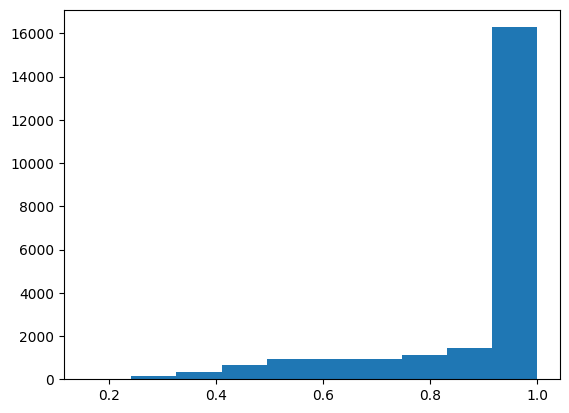

In [58]:
plt.hist(features_shuffled[:, 0])

In [59]:
16276/features_shuffled.shape[0]

0.7135466900482245

(array([   28.,   116.,   289.,   499.,   746.,   762.,   801.,   879.,
         1157., 12971.]),
 array([-4.25890779, -3.77417612, -3.28944421, -2.80471253, -2.31998086,
        -1.83524907, -1.35051739, -0.8657856 , -0.38105386,  0.10367786,
         0.5884096 ]),
 <BarContainer object of 10 artists>)

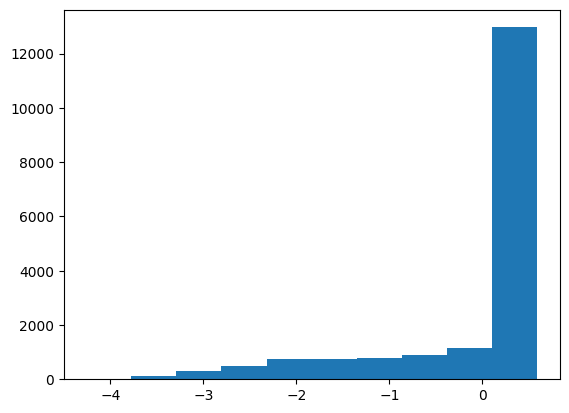

In [57]:
plt.hist(train_features[:, 0])

In [55]:
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {model.coef_[0][i]:.2f}")

conf_max: -0.65
conf_std: -0.22
conf_entropy: -0.38
logit_mean: -0.01
logit_max: 0.46
logit_std: -0.33
logit_diff_top2: 0.41
loss: -0.52
margin_loss: -0.41
conf_ratio: 0.15
top_k_conf_sum: -0.02
energy: -0.45


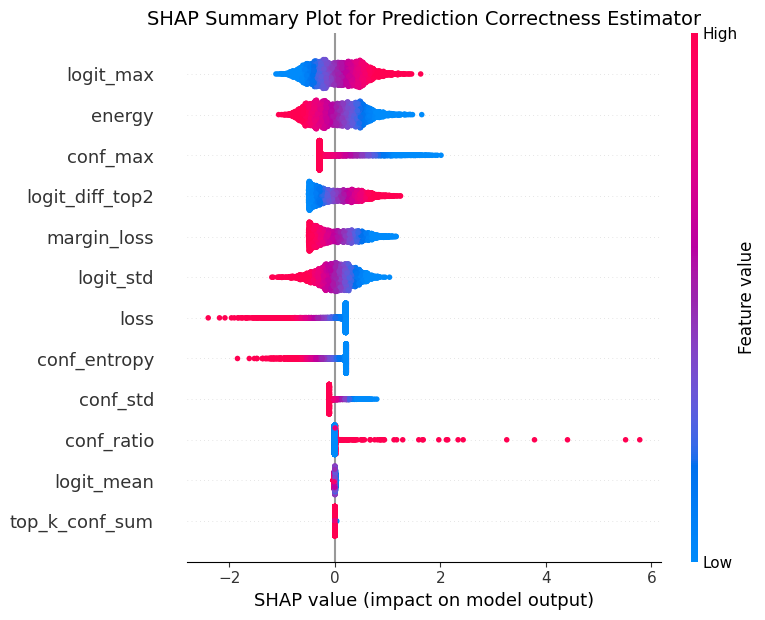

In [43]:
feature_names = [
    "conf_max",
    "conf_std",
    "conf_entropy",
    "logit_mean",
    "logit_max",
    "logit_std",
    "logit_diff_top2",
    "loss",
    "margin_loss",
    "conf_ratio",
    "top_k_conf_sum",
    "energy",
]

explainer = shap.Explainer(model, test_features)
shap_values = explainer(test_features)
# Create the summary plot
shap.summary_plot(shap_values, test_features, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot for Prediction Correctness Estimator", fontsize=14)
plt.tight_layout()
plt.show()

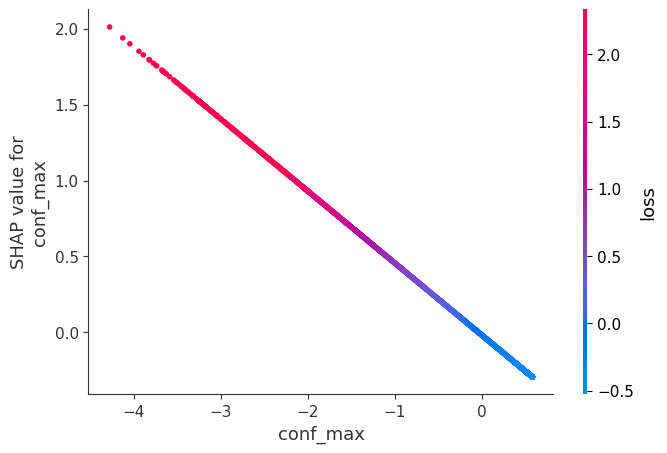

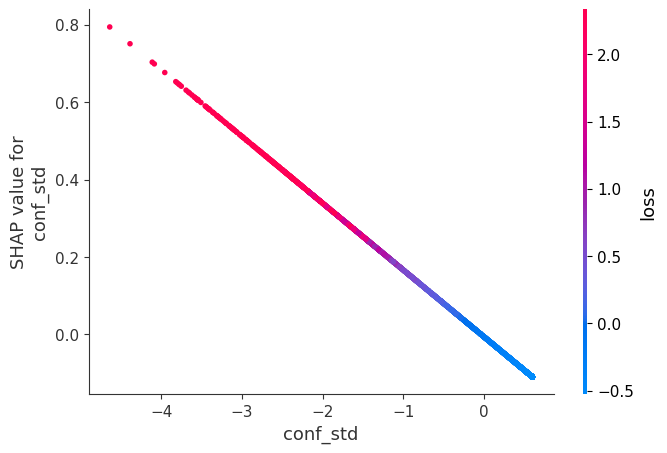

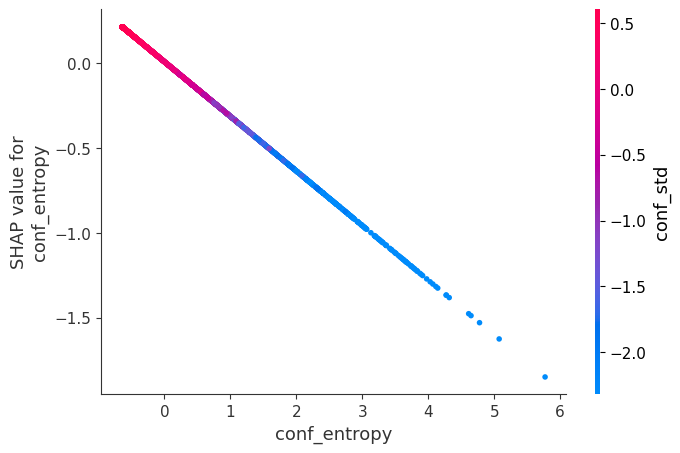

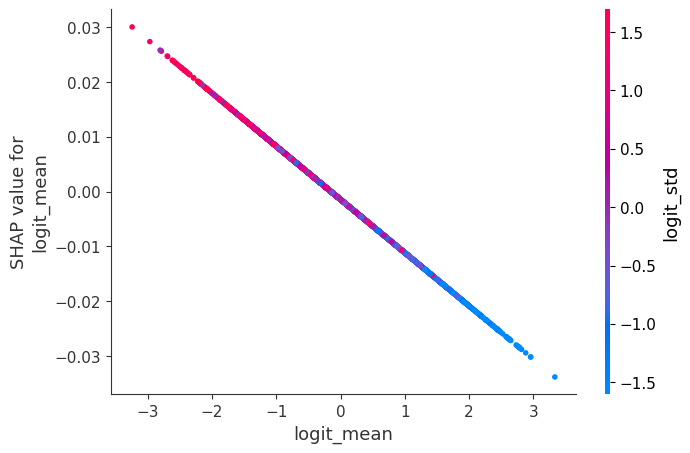

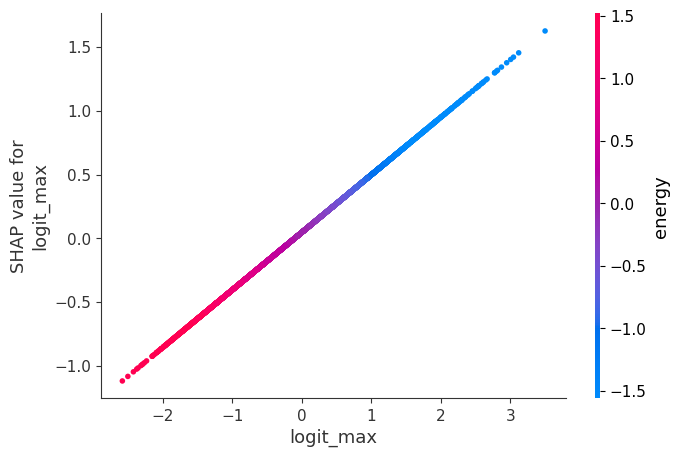

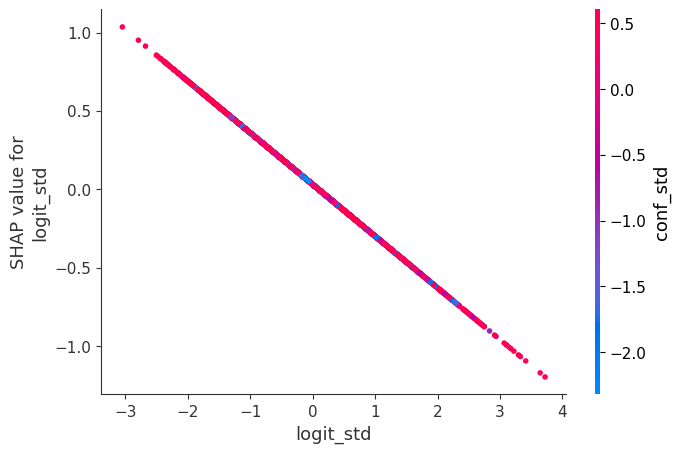

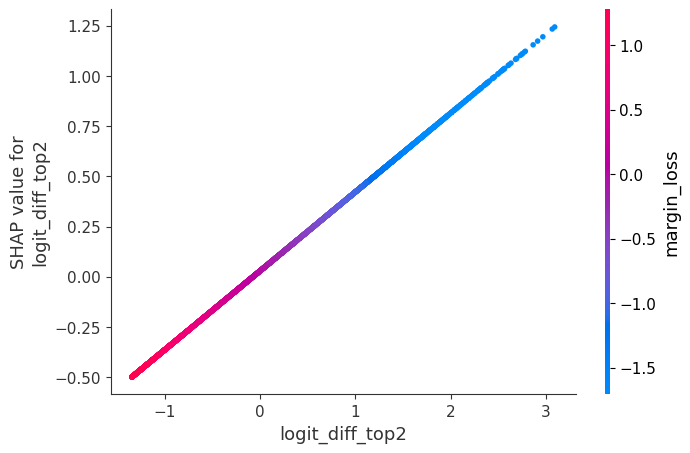

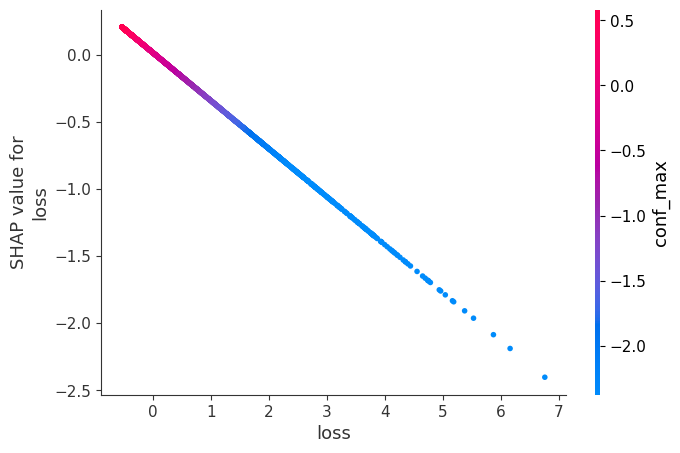

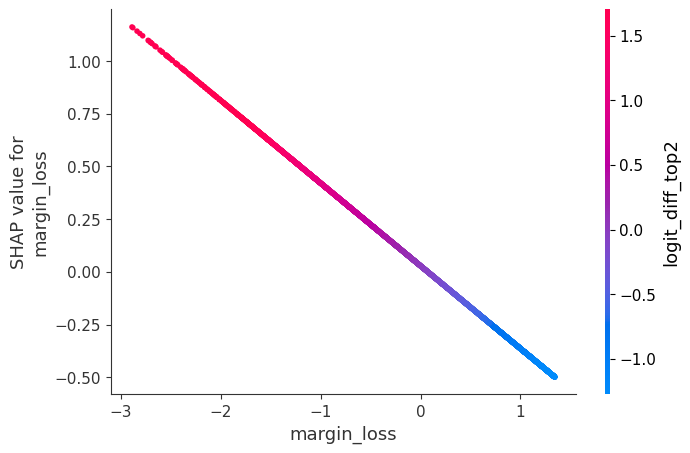

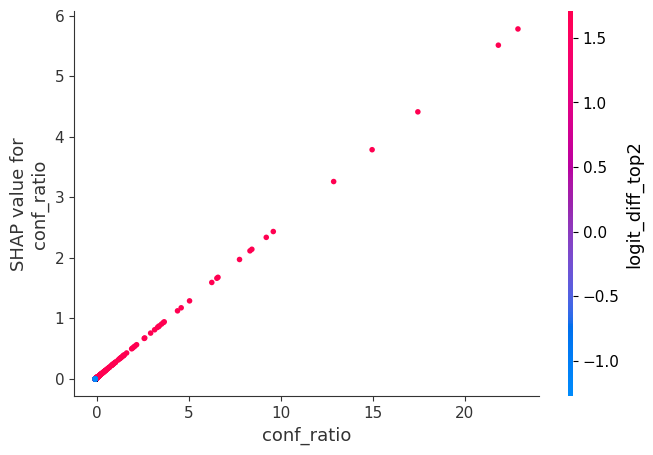

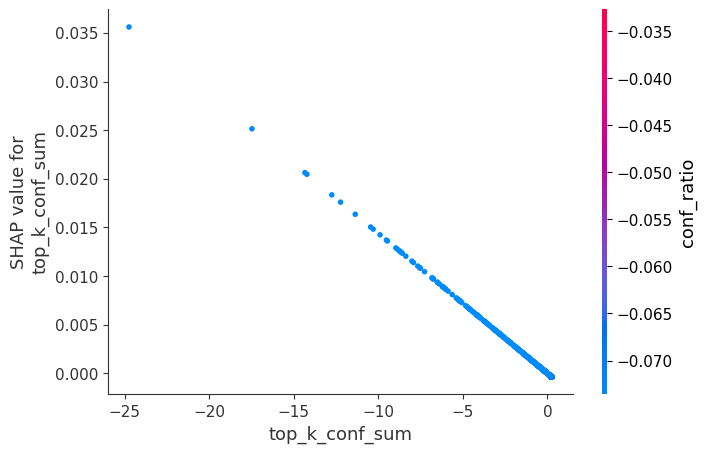

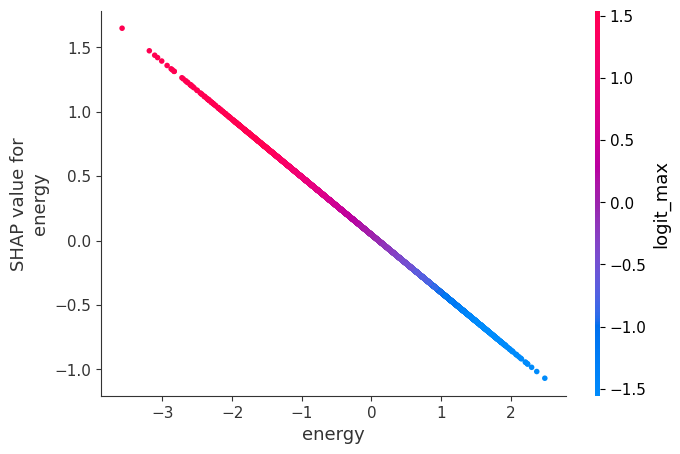

In [44]:
for feature_idx, feature_name in enumerate(feature_names):
    shap.dependence_plot(feature_idx, shap_values.values, test_features, feature_names=feature_names)


ANOVA Results (sorted by decreasing F-value):
Feature: logit_max, F-value: 2236.9575, p-value: 0.0000e+00
Feature: energy, F-value: 2208.7383, p-value: 0.0000e+00
Feature: margin_loss, F-value: 2037.4529, p-value: 0.0000e+00
Feature: logit_diff_top2, F-value: 2034.4954, p-value: 0.0000e+00
Feature: conf_entropy, F-value: 1296.9874, p-value: 0.0000e+00
Feature: conf_std, F-value: 1155.4889, p-value: 0.0000e+00
Feature: conf_max, F-value: 1045.1721, p-value: 0.0000e+00
Feature: loss, F-value: 881.8169, p-value: 0.0000e+00
Feature: logit_mean, F-value: 873.7450, p-value: 0.0000e+00
Feature: top_k_probs_sum, F-value: 249.4943, p-value: 0.0000e+00
Feature: logit_std, F-value: 118.7113, p-value: 2.6222e-27
Feature: class_prob_ratio, F-value: 20.0250, p-value: 7.8298e-06


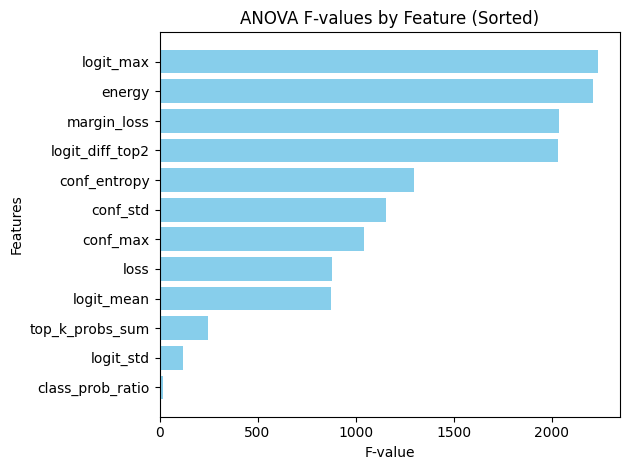

In [35]:
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import numpy as np

# ANOVA Analysis
f_values, p_values = f_classif(test_features, test_corr)

# Combine the results into a list of tuples and sort by F-value in descending order
anova_results = sorted(zip(feature_names, f_values, p_values), key=lambda x: x[1], reverse=True)

# Print sorted ANOVA results
print("\nANOVA Results (sorted by decreasing F-value):")
for name, f_val, p_val in anova_results:
    print(f"Feature: {name}, F-value: {f_val:.4f}, p-value: {p_val:.4e}")

# Extract sorted feature names and F-values for plotting
sorted_feature_names = [x[0] for x in anova_results]
sorted_f_values = [x[1] for x in anova_results]

# Visualize sorted ANOVA F-values
plt.barh(sorted_feature_names, sorted_f_values, color='skyblue')
plt.xlabel("F-value")
plt.ylabel("Features")
plt.title("ANOVA F-values by Feature (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to display the highest F-value at the top
plt.tight_layout()
plt.show()
